<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = Stu. No. 1
            <br />
            Name = ...   
            <br />
            Last_Name = ...
        </div>
        <div class="column">
        <br />
            student_number = Stu. No. 2
            <br />
            Name = ...   
            <br />
            Last_Name = ...
        </div>
    </font>
    </div>


1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

# Import Necessary Libraries

In [ ]:
import gc
gc.collect()

!kill -9 -1

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2023-08-05 21:26:18--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2023-08-05 21:26:19--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  24.4MB/s    in 2m 20s  

2023-08-05 21:28:39 (24.1 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [ ]:
!mkdir div2k_dataset
!unzip -q DIV2K_train_HR.zip -d div2k_dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip -q DIV2K_valid_HR.zip -d div2k_dataset

--2023-08-05 21:39:08--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2023-08-05 21:39:08--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  23.9MB/s    in 19s     

2023-08-05 21:39:28 (22.1 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]



In [2]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg19
import torch.nn as nn
from matplotlib import pyplot as plt
from typing import Dict
import os
from glob import glob
import cv2
from PIL import Image
import math
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import imgaug as ia
import imgaug.augmenters as iaa
import pickle
from numba import cuda

hr_heigth = 256
hr_width = 256

# Load Dataset and Prepare It

In [ ]:
myTransforms1 = transforms.Compose([
    transforms.Resize((hr_heigth,hr_width))
])

myTransforms2 = transforms.Compose([
          transforms.Resize((hr_heigth+50,hr_width+50)),
          transforms.RandomCrop((256,256)),
          transforms.ColorJitter(brightness=0.5),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomGrayscale(),
      ])


train_path = './div2k_dataset/DIV2K_train_HR/'
files = os.listdir(train_path)
train_imgs = []

# original images
for file in files:
  img = Image.open(os.path.join(train_path,file))
  train_imgs.append(myTransforms1(img))

# agumented images
for _ in range(9):
  for file in files:
    img = Image.open(os.path.join(train_path,file))
    train_imgs.append(myTransforms2(img))

test_path = './div2k_dataset/DIV2K_valid_HR/'
files = os.listdir(test_path)
test_imgs = []
for file in files:
  img = Image.open(os.path.join(test_path,file))
  test_imgs.append(myTransforms1(img))

with open('train_imgs','wb') as fp:
  pickle.dump(train_imgs,fp)
with open('test_imgs','wb') as fp:
  pickle.dump(test_imgs,fp)

In [3]:
with open('train_imgs','rb') as fp:
  train_imgs = pickle.load(fp)
with open('test_imgs','rb') as fp:
  test_imgs = pickle.load(fp)

In [4]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self,imgs, scale=4):

        self.files = imgs

        # Transforms for low resolution images and high resolution images
        hr_height, hr_width = (256,256)

        self.hr_transform = transforms.Compose([
          transforms.Resize((hr_heigth,hr_width)),
          transforms.ToTensor()
      ])
        self.lr_transform = transforms.Compose([
          transforms.Resize((hr_heigth//4,hr_width//4)),
          transforms.ToTensor(),
          transforms.Normalize(mean,std)
      ])

    def __getitem__(self, index):
        img = self.files[index]
        img_hr = self.hr_transform(img)
        img_hr = img_hr*2 - 1
        img_lr = self.lr_transform(img)
        return (img_lr, img_hr)

    def __len__(self):
        return len(self.files)

In [5]:
batch_size = 32
train_set = ImageDataset(imgs=train_imgs)
test_set = ImageDataset(imgs=test_imgs)
trainLoader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoader = DataLoader(test_set,batch_size=1,shuffle=True)

# Define Your Model
torch neural network model

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)


class SRResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(SRResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU()
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.AdaptiveAvgPool2d((4,4)))
        layers.extend([nn.Flatten(),nn.Linear(8192,1024),nn.LeakyReLU(0.2),nn.Linear(1024, 1)])
        #layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


# Fit The Model
Also Define optimizer, Criterion and other parameters

In [7]:
learning_rate = 0.0001
epoch_nums = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_model = SRResNet().to(device)
criterion = nn.MSELoss().to(device)
b1 = 0.5
b2 = 0.999
optimizer = torch.optim.Adam(params=generator_model.parameters(), lr=learning_rate, betas=(b1,b2))
batch_num = len(trainLoader)
losses = []
for epoch in range(epoch_nums):  # loop over the dataset multiple times

    running_loss = 0.0
    tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len(trainLoader)))
    generator_model.train()
    for i, imgs in enumerate(tqdm_bar):
        ## FILL HERE
        ## You should train the model and also print the running loss for each batch
        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        sr = generator_model(lr)
        optimizer.zero_grad()
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    running_loss /= batch_num
    losses.append(running_loss)
    print('epoch : ',epoch,', loss : ',running_loss)
print('Finished Training')


Training Epoch 0 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  0 , loss :  0.046487925827503204


Training Epoch 1 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  1 , loss :  0.02692086984962225


Training Epoch 2 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  2 , loss :  0.024209618985652923


Training Epoch 3 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  3 , loss :  0.02252575361356139


Training Epoch 4 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  4 , loss :  0.030284667015075685


Training Epoch 5 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  5 , loss :  0.02182860644161701


Training Epoch 6 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  6 , loss :  0.020324778988957404


Training Epoch 7 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  7 , loss :  0.0206566862128675


Training Epoch 8 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  8 , loss :  0.019500608198344708


Training Epoch 9 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  9 , loss :  0.019057283326983452


Training Epoch 10 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  10 , loss :  0.018866111941635608


Training Epoch 11 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  11 , loss :  0.018507959358394145


Training Epoch 12 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  12 , loss :  0.018781492963433264


Training Epoch 13 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  13 , loss :  0.018444820720702408


Training Epoch 14 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  14 , loss :  0.018572128266096114


Training Epoch 15 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  15 , loss :  0.017883928436785938


Training Epoch 16 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  16 , loss :  0.01781409839168191


Training Epoch 17 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  17 , loss :  0.017559533827006816


Training Epoch 18 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  18 , loss :  0.01747094002738595


Training Epoch 19 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  19 , loss :  0.017522449124604465
Finished Training


In [8]:
# save model
torch.save(generator_model.state_dict(), '/content/drive/MyDrive/SRResNet_model.pth')

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
normalize = transforms.Normalize(mean,std)
learning_rate = 0.0001
epoch_nums = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_model = SRResNet()
generator_model.load_state_dict(torch.load('/content/drive/MyDrive/SRResNet_model.pth'))
generator_model = generator_model.to(device)
discriminator_model = Discriminator(input_shape=(3, hr_heigth, hr_width)).to(device)
feature_extractor_model = FeatureExtractor()
feature_extractor_model.eval()
feature_extractor_model = feature_extractor_model.to(device)


criterion_content = torch.nn.MSELoss().to(device)
criterion_adversarial = torch.nn.BCEWithLogitsLoss().to(device)

b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(params=generator_model.parameters(), lr=learning_rate, betas=(b1,b2))
optimizer_D = torch.optim.Adam(params=discriminator_model.parameters(), lr=learning_rate, betas=(b1,b2))

batch_num = len(trainLoader)
losses = []

for epoch in range(epoch_nums):  # loop over the dataset multiple times
    generator_model.train()
    discriminator_model.train()
    running_loss = []
    tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len(trainLoader)))

    for i, imgs in enumerate(tqdm_bar):
        ## FILL HERE
        ## You should train the model and also print the running loss for each batch

        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        hr = normalize((hr+1)/2)

        valid = Variable(Tensor(np.ones((lr.size(0), *discriminator_model.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((lr.size(0), *discriminator_model.output_shape))), requires_grad=False)

        sr = generator_model(lr)
        sr = normalize((sr+1)/2)
        sr_discriminated = discriminator_model(sr)

        sr_inVGG = feature_extractor_model(sr)
        hr_inVGG = feature_extractor_model(hr).detach()

        content_loss = criterion_content(sr_inVGG, hr_inVGG)
        adv_loss = criterion_adversarial(sr_discriminated,torch.ones_like(sr_discriminated))
        loss = content_loss + 0.001 * adv_loss

        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

        sr_discriminated = discriminator_model(sr.detach())
        hr_discriminated = discriminator_model(hr)

        adv_loss = criterion_adversarial(sr_discriminated, torch.zeros_like(sr_discriminated)) + criterion_adversarial(hr_discriminated, torch.ones_like(hr_discriminated))
        optimizer_D.zero_grad()
        adv_loss.backward()
        optimizer_D.step()

        running_loss.extend([loss.item(),adv_loss.item()])

    running_loss = [l/batch_num for l in running_loss]
    losses.append(running_loss)
    print('epoch : ',epoch,', loss : ',running_loss)
print('Finished Training')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.4MB/s]


Training Epoch 0 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  0 , loss :  [0.056166553497314455, 0.005549281597137451, 0.05522332763671875, 0.005846901416778565, 0.053506309509277344, 0.008137354850769043, 0.04736835861206055, 0.005506591796875, 0.04682439804077149, 0.006177661895751953, 0.054949436187744144, 0.0054931163787841795, 0.05069214630126953, 0.005605801105499268, 0.05279450607299805, 0.005387681007385254, 0.042315345764160156, 0.005368842124938965, 0.04652615737915039, 0.005185962200164795, 0.04411275100708008, 0.005168608665466309, 0.04141168594360352, 0.0050297145843505855, 0.045932239532470706, 0.004804718017578125, 0.050311199188232424, 0.004480081558227539, 0.04902735137939453, 0.00447632884979248, 0.049030914306640624, 0.006612615585327148, 0.045746864318847655, 0.006197015762329102, 0.04565554046630859, 0.004171411991119384, 0.0480574722290039, 0.004493048191070556, 0.04294704437255859, 0.0035155692100524902, 0.048865013122558594, 0.0027596776485443114, 0.04373029708862305, 0.003951933860778809, 0.04841984939575195, 0.0

Training Epoch 1 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  1 , loss :  [0.047107166290283206, 0.00022363418340682982, 0.050722423553466796, 0.0004001603722572327, 0.043658084869384765, 0.00010806980729103088, 0.043736923217773435, 0.0005543586611747741, 0.04852387619018555, 0.0003217359483242035, 0.038756553649902346, 0.00017121320962905885, 0.03958557510375976, 0.00019433075189590455, 0.040592823028564456, 8.459622412919998e-05, 0.042861324310302734, 7.06905573606491e-05, 0.045740463256835937, 6.0328710824251174e-05, 0.048207984924316404, 3.4644082188606265e-05, 0.04464900970458984, 2.9371483251452445e-05, 0.03811702728271484, 6.242913007736206e-05, 0.050785228729248046, 4.108000919222832e-05, 0.0467933235168457, 6.534717977046967e-05, 0.042730335235595704, 3.38301993906498e-05, 0.0439684944152832, 0.00011643557995557784, 0.044448707580566404, 3.865381330251694e-05, 0.04298907089233398, 5.145706981420517e-05, 0.046220836639404295, 3.3829327672719955e-05, 0.04261484146118164, 3.2472804188728335e-05, 0.04113501358032227, 4.642496258020

Training Epoch 2 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  2 , loss :  [0.04150407791137695, 8.388763293623924e-06, 0.03613261032104492, 1.3742031529545784e-05, 0.051667156219482424, 3.5413759760558603e-06, 0.04614391708374024, 6.1538107693195346e-06, 0.043344951629638674, 2.060670405626297e-05, 0.04429288864135742, 6.490997038781643e-06, 0.04342693328857422, 8.151168003678322e-06, 0.04148188400268555, 5.485991016030311e-06, 0.03915435791015625, 4.279909655451775e-06, 0.044531223297119144, 7.78299942612648e-06, 0.04203721618652344, 6.519987247884274e-06, 0.04271448516845703, 5.973063409328461e-06, 0.046642829895019534, 7.274210453033447e-06, 0.040239154815673826, 1.0480090975761414e-05, 0.04587958145141602, 1.0804175399243832e-05, 0.039235157012939455, 7.845109328627586e-06, 0.04140553283691406, 3.6149162333458662e-06, 0.041810928344726564, 7.099024951457978e-06, 0.03858436584472656, 1.8293213099241255e-05, 0.04145271682739258, 6.174491718411446e-06, 0.04095954513549805, 1.0782706551253796e-05, 0.041783199310302735, 8.84661078453064e-

Training Epoch 3 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  3 , loss :  [0.037896343231201175, 1.915247761644423e-06, 0.03852608489990234, 1.7293442506343126e-06, 0.05044759368896484, 2.121350960806012e-06, 0.038869110107421875, 1.5387216117233038e-06, 0.04429459762573242, 9.692981257103384e-07, 0.03941533660888672, 1.4560162089765073e-06, 0.040464149475097654, 1.2332790065556765e-06, 0.04004069900512695, 1.5041254227980971e-06, 0.04760301971435547, 1.5043229795992374e-06, 0.04489448928833008, 9.074986446648836e-07, 0.04595793914794922, 1.133752753958106e-06, 0.03990207290649414, 1.0737491538748145e-06, 0.04072043228149414, 8.78032180480659e-07, 0.03758852767944336, 1.3988467399030924e-06, 0.042707225799560544, 9.620513883419336e-07, 0.03501250839233398, 2.2695239167660477e-06, 0.044749732971191405, 1.6326579498127102e-06, 0.039685783386230467, 1.4922023983672262e-06, 0.035548095703125, 2.3033826146274804e-06, 0.03713058471679687, 1.0864583309739828e-06, 0.04237960815429687, 1.1179945431649685e-06, 0.040988616943359375, 1.5366820152848

Training Epoch 4 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  4 , loss :  [0.04367890548706055, 6.994372815825045e-07, 0.04945797348022461, 7.545131957158446e-07, 0.040624061584472654, 8.303237846121192e-07, 0.03908541488647461, 5.816408665850758e-07, 0.040567138671875, 1.8118983134627342e-06, 0.03828860473632813, 9.242464439012111e-07, 0.04358697509765625, 6.529902457259596e-07, 0.04235659408569336, 3.2688575447537007e-07, 0.04158094024658203, 1.3730552745983004e-06, 0.04270182800292969, 3.8020272040739653e-07, 0.04169804000854492, 7.033900474198162e-07, 0.04634829330444336, 2.1884758025407793e-06, 0.03842106628417969, 6.464237812906504e-07, 0.04594115447998047, 5.081657436676323e-07, 0.04706436157226562, 5.026403814554215e-07, 0.044389194488525394, 9.581969934515655e-07, 0.04059062957763672, 1.0025581577792763e-06, 0.038516319274902344, 8.804670069366694e-07, 0.04721372985839844, 4.2870687320828436e-07, 0.03966918182373047, 7.656872039660812e-07, 0.04021255874633789, 6.092395633459092e-07, 0.04335165786743164, 3.880083560943603e-06, 0.

Training Epoch 5 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  5 , loss :  [0.044680950164794925, 2.0771613344550133e-07, 0.04672187423706055, 7.843677885830402e-07, 0.03679686737060547, 3.7839903961867094e-06, 0.03663582229614258, 5.034036003053188e-07, 0.0422935676574707, 2.167474594898522e-07, 0.04159682083129883, 8.021523244678974e-07, 0.04263582229614258, 2.9204218299128116e-07, 0.042879405975341796, 1.1393199383746832e-07, 0.03932213592529297, 2.9549578903242944e-07, 0.04419301986694336, 2.3745253565721213e-07, 0.04184625244140625, 8.58066021464765e-07, 0.040542118072509764, 2.314755547558889e-07, 0.0380454216003418, 6.049972726032138e-07, 0.035409561157226564, 8.354973397217691e-07, 0.042775009155273436, 2.985960454680026e-07, 0.0450406494140625, 3.289033775217831e-07, 0.03618202590942383, 6.628656410612166e-07, 0.04255896377563476, 2.412759349681437e-07, 0.051196990966796876, 2.0778042380698025e-07, 0.04311294937133789, 1.5126054640859366e-06, 0.03299081802368164, 2.555869286879897e-07, 0.04434822845458984, 1.5302188694477082e-07,

Training Epoch 6 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  6 , loss :  [0.039320125579833984, 1.496022567152977e-05, 0.03671407318115234, 4.559461958706379e-06, 0.03452718353271484, 3.38531075976789e-06, 0.0433660888671875, 2.8981768991798164e-06, 0.04004875564575195, 2.6458743959665297e-06, 0.039310791015625, 5.6714443489909176e-06, 0.03746084594726563, 7.923293858766556e-06, 0.03614230346679687, 2.1060968283563853e-06, 0.0412047233581543, 6.251432001590729e-05, 0.03996587371826172, 7.453856524080038e-06, 0.03653910827636719, 1.4422631822526456e-05, 0.04057263946533203, 3.5694781690835956e-05, 0.03877006149291992, 2.4293269962072373e-05, 0.04052923202514649, 3.950086422264576e-06, 0.04107737350463867, 9.468835778534412e-06, 0.039560562133789064, 3.7422364111989735e-06, 0.037399757385253904, 4.150393418967724e-06, 0.04068155288696289, 4.294586833566427e-06, 0.04046673583984375, 2.9673448298126458e-06, 0.04284296798706055, 2.993791364133358e-06, 0.03939754867553711, 2.3369430564343927e-06, 0.04114880752563477, 5.494509357959032e-06, 0.

Training Epoch 7 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  7 , loss :  [0.045289779663085936, 3.797776298597455e-07, 0.03731756591796875, 1.241020392626524e-06, 0.041691951751708985, 4.596494836732745e-07, 0.038533031463623045, 2.2138936910778285e-06, 0.036837112426757815, 6.267558783292771e-07, 0.04290587615966797, 7.745687616989016e-07, 0.03892753982543945, 1.1032948968932032e-06, 0.03305609512329102, 1.9427137449383735e-06, 0.040446941375732424, 1.3162327231839298e-06, 0.04680552673339844, 6.191730499267578e-07, 0.03233402633666992, 1.107804011553526e-06, 0.042393257141113284, 3.8956000935286284e-07, 0.04332022476196289, 7.196754449978471e-07, 0.047213478088378905, 4.228173929732293e-07, 0.03640522003173828, 5.54784550331533e-07, 0.03936850357055664, 1.7273032572120429e-06, 0.037372764587402345, 9.313456248492003e-07, 0.03835738372802734, 4.6902955509722235e-06, 0.037612335205078125, 5.217349389567971e-07, 0.044677177429199216, 6.957817822694779e-07, 0.042605484008789066, 1.163030043244362e-06, 0.039859691619873044, 1.4067757874727

Training Epoch 8 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  8 , loss :  [0.03217038345336914, 1.8747816793620587e-06, 0.04179275894165039, 4.464366065803915e-07, 0.035734600067138675, 4.885275848209858e-07, 0.03509835433959961, 2.988135092891753e-07, 0.033620437622070315, 4.3537173769436777e-07, 0.041703590393066405, 2.861472312361002e-07, 0.035528396606445314, 1.0713261552155018e-05, 0.03807980728149414, 3.7399260327219964e-07, 0.03821784210205078, 6.556902080774308e-07, 0.03956092071533203, 4.568856093101203e-07, 0.036295825958251954, 3.612280706875026e-07, 0.04082683563232422, 3.621941723395139e-07, 0.03811730194091797, 3.766926529351622e-07, 0.04302279281616211, 5.190725205466151e-07, 0.0430458984375, 5.653463304042816e-07, 0.03558134841918945, 4.811600083485245e-07, 0.03316786956787109, 2.809332509059459e-07, 0.041301162719726565, 3.213748859707266e-07, 0.03701624298095703, 1.2650380376726388e-06, 0.03573392868041992, 7.268891204148531e-07, 0.03666045761108398, 1.9058139878325165e-07, 0.03646207427978516, 5.908305756747723e-07, 0.

Training Epoch 9 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  9 , loss :  [0.04230836868286133, 1.6535117174498736e-07, 0.03539517593383789, 2.2455061844084412e-07, 0.04007907104492187, 2.1977814321871848e-07, 0.03912154388427734, 9.494438418187201e-07, 0.04144077301025391, 1.811883266782388e-07, 0.036940608978271484, 1.8451620417181402e-07, 0.03541866302490235, 2.4988994118757547e-07, 0.03968991470336914, 1.0487280815141276e-07, 0.038721820831298825, 1.230220077559352e-06, 0.03579574966430664, 2.4461743305437267e-07, 0.03560550689697266, 1.2801292177755385e-07, 0.04603623962402344, 1.1698673188220709e-07, 0.03951861190795898, 3.0471436912193897e-07, 0.036503917694091795, 4.4303835602477195e-07, 0.039204887390136715, 2.0445702830329538e-07, 0.0361056137084961, 3.591870190575719e-07, 0.036467060089111325, 2.601251762825996e-07, 0.0319693603515625, 2.2499734768643976e-07, 0.0360473518371582, 7.247802568599582e-08, 0.037587711334228516, 1.475611643400043e-07, 0.03652687835693359, 3.371963102836162e-07, 0.038679054260253906, 9.88966930890455

Training Epoch 10 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  10 , loss :  [0.0320491943359375, 3.4073845017701385e-07, 0.039344627380371096, 1.837526506278664e-07, 0.033681331634521486, 1.7868954455479979e-07, 0.04171893692016602, 1.1744887160602956e-07, 0.03700311660766602, 1.6640793182887137e-07, 0.03936508941650391, 1.4270469546318055e-07, 0.036872776031494144, 3.909969818778336e-07, 0.037119613647460935, 1.6912168939597904e-07, 0.04008407592773437, 1.6567746934015304e-07, 0.03890108489990234, 1.7238210421055555e-07, 0.0368217658996582, 1.0406809451524168e-07, 0.043817459106445314, 1.0610940807964653e-07, 0.04678516006469727, 2.521414426155388e-07, 0.040765430450439455, 2.7516606496647e-07, 0.0415814094543457, 1.7169755301438273e-07, 0.03869307708740234, 2.19271780224517e-07, 0.03400871276855469, 1.9477898604236544e-07, 0.03539577102661133, 2.5741226272657515e-07, 0.035723690032958985, 1.0317402484361082e-07, 0.03669609069824219, 1.6161089297384025e-07, 0.038566619873046874, 1.3368940562941135e-07, 0.041134151458740234, 1.55248388182

Training Epoch 11 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  11 , loss :  [0.041585723876953126, 8.162728045135736e-08, 0.03877844619750977, 1.533305156044662e-06, 0.04069291305541992, 7.088379061315208e-08, 0.032552417755126954, 3.2549534807913004e-07, 0.03329405975341797, 1.963592367246747e-07, 0.03497195816040039, 6.915548146935179e-08, 0.035834217071533205, 3.661514783743769e-07, 0.03840622329711914, 1.676817482803017e-07, 0.03411125946044922, 9.128207602770999e-08, 0.03907498168945313, 1.480675709899515e-07, 0.039798114776611326, 1.2443667219486087e-07, 0.03730654144287109, 8.45182003104128e-08, 0.03883581924438476, 7.741053559584543e-08, 0.03977412033081055, 7.82897914177738e-08, 0.04207634735107422, 9.403968579135835e-08, 0.04207912826538086, 9.096980647882447e-08, 0.03963533782958984, 4.505954857449979e-07, 0.0358526725769043, 1.9835648708976805e-07, 0.0344827995300293, 4.145326965954155e-07, 0.032435890197753905, 5.159257561899722e-07, 0.041660423278808596, 6.297146319411695e-08, 0.040265674591064456, 2.7595856226980685e-07, 0.

Training Epoch 12 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  12 , loss :  [0.037554885864257814, 1.5150952094700188e-07, 0.03458888626098633, 1.4994728844612837e-06, 0.03210896682739258, 5.298801261233166e-08, 0.036345024108886716, 2.265029470436275e-07, 0.037767627716064456, 4.571645695250481e-08, 0.042265541076660154, 5.8009296481031925e-08, 0.04126696014404297, 9.8910451924894e-08, 0.041054931640625, 1.145195128628984e-07, 0.039645423889160154, 2.2848218213766813e-07, 0.035977619171142575, 6.726286665070802e-08, 0.041588973999023435, 1.1817812628578395e-07, 0.036327022552490235, 9.053786925505847e-08, 0.03505371856689453, 8.596383850090206e-08, 0.04176315689086914, 7.025766535662114e-08, 0.038979381561279294, 1.3321631122380494e-06, 0.044753719329833984, 1.9764978787861764e-07, 0.04066874313354492, 1.028730475809425e-07, 0.045010677337646486, 4.449448897503316e-08, 0.042778396606445314, 7.575634663226083e-08, 0.03389606475830078, 6.036393824615516e-08, 0.036464786529541014, 4.5239437895361335e-08, 0.03555052185058594, 3.0070321372477

Training Epoch 13 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  13 , loss :  [0.03501698303222656, 6.460872828029096e-08, 0.03974211883544922, 9.006005711853504e-08, 0.037953559875488284, 9.27723667700775e-08, 0.03954052352905273, 1.1825060209957882e-07, 0.04310269165039062, 4.84428383060731e-08, 0.035789096832275394, 9.26982902456075e-08, 0.046469264984130856, 2.133834823325742e-08, 0.031854619979858396, 6.64487131871283e-07, 0.04362980270385742, 1.0863241186598316e-07, 0.04249234008789062, 8.345905371243134e-08, 0.03309865570068359, 1.078808491001837e-07, 0.038701953887939455, 3.582213685149327e-08, 0.035834640502929685, 8.156192780006677e-08, 0.03138893699645996, 1.2000841525150462e-07, 0.03968584823608398, 4.7414352593477813e-08, 0.04136101150512695, 6.912113894941285e-08, 0.03793572616577148, 4.355564306024462e-08, 0.035517005920410155, 1.4455808559432626e-07, 0.04302336120605469, 1.7881342500913887e-08, 0.03211842346191406, 5.540179699892178e-08, 0.03344549560546875, 5.7770732382778076e-08, 0.03874085998535156, 2.1876345854252576e-06

Training Epoch 14 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  14 , loss :  [0.0375443229675293, 3.510651004035026e-08, 0.03674958419799805, 4.5463097194442524e-08, 0.036076400756835936, 7.898259354988113e-08, 0.03132804107666016, 1.1360352800693362e-07, 0.042480712890625, 4.6148277760948985e-08, 0.03933454513549805, 3.3110252843471244e-08, 0.0325457649230957, 1.8646397802513093e-07, 0.033733566284179686, 1.1649095540633425e-07, 0.038174236297607425, 3.434689278947189e-08, 0.03178722953796387, 1.824982900870964e-07, 0.0368634033203125, 4.1871509893098846e-08, 0.03576273727416992, 7.028251275187358e-08, 0.03597763824462891, 1.12886045826599e-07, 0.0376754264831543, 4.0977345634019e-08, 0.042283058166503906, 3.555362491169945e-08, 0.0371818962097168, 6.031933298800141e-08, 0.036590465545654295, 9.028373460751027e-08, 0.033641250610351565, 6.270330050028861e-08, 0.03884580612182617, 2.6568624889478086e-08, 0.037608020782470705, 5.1839353545801715e-08, 0.050218391418457034, 2.123407284670975e-08, 0.03680775833129883, 5.6131808378268034e-08, 0

Training Epoch 15 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  15 , loss :  [0.03753265380859375, 3.4063810744555664e-08, 0.036185016632080076, 4.313819226808846e-08, 0.03400379943847656, 8.757135947234929e-08, 0.0356491584777832, 3.4734137443592775e-08, 0.036286426544189454, 7.939159695524722e-08, 0.039534088134765624, 1.6094003804028034e-06, 0.03664619827270508, 3.035346890101209e-08, 0.03539468383789063, 4.7161360271275043e-08, 0.043426963806152345, 8.898696978576481e-08, 0.03689080810546875, 7.00177697581239e-08, 0.031896306991577146, 6.340324762277304e-08, 0.03520008087158203, 1.8435309175401925e-07, 0.04421700668334961, 2.4065266188699753e-08, 0.03949260330200195, 3.0919713026378306e-08, 0.037157066345214845, 4.4703065213980154e-08, 0.03056668472290039, 1.3356089766602964e-07, 0.0395575065612793, 2.6792076823767275e-08, 0.03803939819335937, 2.7209400286665186e-08, 0.03832301330566406, 3.415331229916774e-08, 0.03398495483398437, 4.742902819998562e-08, 0.03709257888793945, 2.6583424187265336e-08, 0.03584380722045898, 1.33116845972836e

Training Epoch 16 :   0%|          | 0/250 [00:00<?, ?it/s]

epoch :  16 , loss :  [0.038289207458496094, 6.314933125395328e-08, 0.0415745849609375, 1.0161988029722125e-07, 0.04011901092529297, 7.384928176179528e-08, 0.03741033172607422, 2.1129781089257448e-08, 0.04223921966552734, 3.208198904758319e-08, 0.03177090263366699, 6.337377999443561e-08, 0.03928206634521485, 1.6659450920997186e-08, 0.04150797653198242, 1.5586540030199102e-08, 0.03478762435913086, 1.816122676245868e-07, 0.040365268707275394, 3.743128036148846e-08, 0.03370444107055664, 6.579886394320055e-08, 0.03308187484741211, 4.264675953891128e-08, 0.03209931945800781, 2.340964783797972e-08, 0.04422573852539063, 1.2710657756542787e-08, 0.039409576416015626, 5.635492561850697e-08, 0.035561679840087894, 8.235304267145693e-08, 0.03769197082519531, 3.1336898246081546e-08, 0.02932975387573242, 3.386993921594694e-08, 0.043393119812011716, 9.626133760320954e-09, 0.039215938568115234, 2.8192698664497585e-08, 0.03958831024169922, 1.835817784012761e-08, 0.037040729522705075, 6.143493374111131e-

Training Epoch 17 :   0%|          | 0/250 [00:00<?, ?it/s]

In [8]:
# save model
torch.save(generator_model.state_dict(), '/content/drive/MyDrive/SRGAN_generator.pth')
torch.save(discriminator_model.state_dict(), '/content/drive/MyDrive/SRGAN_discriminator.pth')

# Plot The Results

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load SRResNet model
srres_model = SRResNet()
srres_model.load_state_dict(torch.load('/content/drive/MyDrive/SRResNet_model.pth'))
srres_model = srres_model.to(device)

# load SRGAN model
srgan_model = SRResNet()
srgan_model.load_state_dict(torch.load('/content/drive/MyDrive/SRGAN_generator.pth'))
srgan_model = srgan_model.to(device)

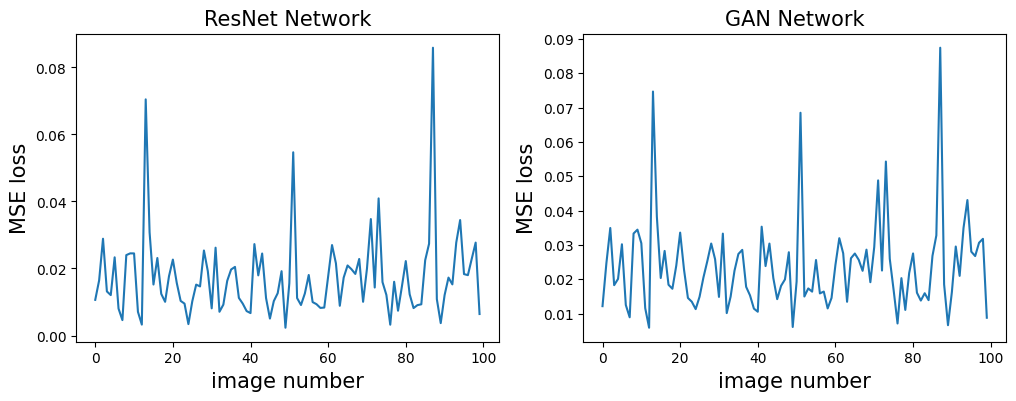

In [10]:
criterion = nn.MSELoss().to(device)

losses_res = []
losses_gan = []
low_res_images = []
ResNet_super_res_images = []
GAN_super_res_images = []
high_res_images = []

with torch.no_grad():
    srres_model.eval()
    srgan_model.eval()
    for i, imgs in enumerate(testLoader):
        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        sr_res = srres_model(lr)
        sr_gan = srgan_model(lr)
        loss = criterion(sr_res, hr)
        losses_res.append(loss.item())
        loss = criterion(sr_gan, hr)
        losses_gan.append(loss.item())
        ResNet_super_res_images.append(torch.squeeze(sr_res.cpu(),dim=0))
        GAN_super_res_images.append(torch.squeeze(sr_gan.cpu(),dim=0))
        low_res_images.append(torch.squeeze(lr.cpu(),dim=0))
        high_res_images.append(torch.squeeze(hr.cpu(),dim=0))

ResNet_super_res_images = torch.stack(ResNet_super_res_images,dim=0)
GAN_super_res_images = torch.stack(GAN_super_res_images,dim=0)
low_res_images = torch.stack(low_res_images,dim=0)
high_res_images = torch.stack(high_res_images,dim=0)

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(range(0,100),losses_res)
plt.xlabel('image number',fontsize=15)
plt.ylabel('MSE loss',fontsize=15)
plt.title('ResNet Network',fontsize=15)

plt.subplot(1,2,2)
plt.plot(range(0,100),losses_gan)
plt.xlabel('image number',fontsize=15)
plt.ylabel('MSE loss',fontsize=15)
plt.title('GAN Network',fontsize=15)
plt.show()

In [11]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

idxs = np.random.randint(0,100,10)
outputs_low = [invTrans(img).permute(1,2,0) for img in low_res_images[idxs,:,:,:]]
outputs_super_res = [((img+1)/2).permute(1,2,0) for img in ResNet_super_res_images[idxs,:,:,:]]
outputs_super_gan = [((img+1)/2).permute(1,2,0) for img in GAN_super_res_images[idxs,:,:,:]]
outputs_high = [((img+1)/2).permute(1,2,0) for img in high_res_images[idxs,:,:,:]]

In [12]:
plt.figure(figsize=(20,40))
plt.subplot(10,4,1)
plt.imshow(outputs_low[0])
plt.title('Low Resolution')
plt.subplot(10,4,2)
plt.imshow(outputs_high[0])
plt.title('High Resolution')
plt.subplot(10,4,3)
plt.imshow(outputs_super_res[0])
plt.title('Super Resolution (ResNet)')
plt.subplot(10,4,4)
plt.imshow(outputs_super_gan[0])
plt.title('Super Resolution (GAN)')
for i in range(1,10):
    plt.subplot(10,4,4*i+1)
    plt.imshow(outputs_low[i])
    plt.subplot(10,4,4*i+2)
    plt.imshow(outputs_high[i])
    plt.subplot(10,4,4*i+3)
    plt.imshow(outputs_super_res[i])
    plt.subplot(10,4,4*i+4)
    plt.imshow(outputs_super_gan[i])

plt.show()

Output hidden; open in https://colab.research.google.com to view.